In [359]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

### Download sequences

In [360]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0   1428      0 --:--:-- --:--:-- --:--:--  1428
100 36.2M  100 36.2M    0     0  10.7M      0  0:00:03  0:00:03 --:--:-- 18.1M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0   1038      0 --:--:-- --:--:-- --:--:--  1038
100 13.8M  100 13.8M    0     0  6219k      0  0:00:02  0:00:02 --:--:-- 11.2M 0     0  1809k 

In [361]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [362]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [363]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [364]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [365]:
df.reason.value_counts()

N                             297033
X                             211189
A[B.1.1.7]                     35832
A[B.1.617.2]                   35457
Y                              25163
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [366]:
import re

In [367]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    x = pd.crosstab(d.lineage.cat.remove_unused_categories() == "None", d.sequencing_pc).T
    #print((x[True] / x.sum(1)).sort_values())
    print(x)

lineage        False  True 
sequencing_pc              
1127.0            74      0
12489.0           55      0
1307.0          1123      2
13353.0          844      0
14467.0         2268      4
1458.0           924     13
16321.0         3972     16
17475.0         1303      6
20095.0         3736      6
20251.0          994      0
21502.0        11420     54
22081.0         2662      8
23845.0          203      0
30159.0         8916     13
30167.0           59      0
30449.0           69      0
3048.0           256      3
32105.0         1325      8
32545.0          727      2
32758.0          167      0
35043.0            3      0
37075.0          156      0
40210.0         2593     13
40225.0         3775     14
40477.0         1582      5
4103.0          1283     12
44137.0         7578      1
44879.0         4194    133
45147.0          288      3
4779.0         34303    338
50858.0        18916    127
50933.0         1926     38
55128.0            4      0
55131.0         1023

In [368]:
import re
d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")

IMS_ID
IMS-10294-CVDP-87A74412-A73F-4B65-AA1B-1D2F60BAD700    False
IMS-10294-CVDP-307E544A-42F4-487F-A925-D7A6E5A3D20E    False
IMS-10294-CVDP-7E903449-A7EF-4A04-8A14-278C1D6C6E68    False
IMS-10294-CVDP-59FB4C41-BD0E-48BC-AC35-73356B52044A    False
IMS-10294-CVDP-1A233FB2-B135-4F49-BFDF-AE612E2E9BF7    False
                                                       ...  
IMS-10280-CVDP-E41BA432-F07E-4CF5-9B68-C8DF8FA5EF95    False
IMS-10280-CVDP-C42370E6-0751-4920-9316-F576D5460864    False
IMS-10280-CVDP-DF4B817C-5D28-48C1-9A5A-548768912F29    False
IMS-10280-CVDP-4B2F46B9-2BF1-44BE-8204-FEDC020940DA    False
IMS-10280-CVDP-254A4EF3-4576-46A6-8A24-3F676EE0A3BE    False
Name: lineage, Length: 253113, dtype: bool

In [369]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-25     0       2     0     0      0          0
                  2022-02-26     0       0     0     0      0          0
                  2022-02-27     0       0     0     0      0          0
                  2022-02-28     0       0     0     0      0          0
                  2022-03-02     0       0     0     0      0          0

[1936 rows x 6 columns]

In [370]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland                                                         
Baden-Württemberg       15485   16204  6085     4     23      41411
Bayern                   2280    3044  1398     0     29       6199
Berlin                    673     642   584     0      5       2888
Brandenburg               888    1213   565     1      0       2851
Bremen                    175     264     1     0      5        837
Hamburg                  3821    3087   778     3     23       3767
Hessen                    930    1372   319     2      1       1643
Mecklenburg-Vorpommern    526     479   269     0      0       2824
Niedersachsen             940    1041   457     0      6       3018
Nordrhein-Westfalen     17830   17901  5834    12    161      26429
Rheinland-Pfalz           268     205    46     0      2       1510
Saarland                  688     902   100     0      4       1776
Sachsen                  4631    6293  1707     2     30      15053
Sachsen-Anhalt           1622     476   687     3      0       3003
Schleswig-Holstein       3074    4085  1753     4      2       3907
Thüringen                 280     452    93     0      8       1702

In [371]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [372]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [373]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [374]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A05-A14      W          2022-03-09  2022-03-09   
            A15-A34      W          2022-03-09  2022-03-09   
            A35-A59      W          2022-03-09  2022-03-09   
            A60-A79      W          2022-03-09  2022-03-09   
            A80+         W          2022-03-09  2022-03-09   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A05-A14      W          2022-03-09                     0   
            A15-A34      W          2022-03-09                     0   
            A35-A59      W          2022-03-09                     0   
            A60-A79      W          2022-03-09                     0   
            A80+         W          2022-03-09                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A05-A14      W          2022-03-09          1              -9   
            A15-A34      W          2022-03-09          1              -9   
            A35-A59      W          2022-03-09          1              -9   
            A60-A79      W          2022-03-09          1              -9   
            A80+         W          2022-03-09          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A05-A14      W          2022-03-09          -9          28   
            A15-A34      W          2022-03-09          -9          62   
            A35-A59      W          2022-03-09          -9          81   
            A60-A79      W          2022-03-09          -9          25   
            A80+         W          2022-03-09          -9           7   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [375]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

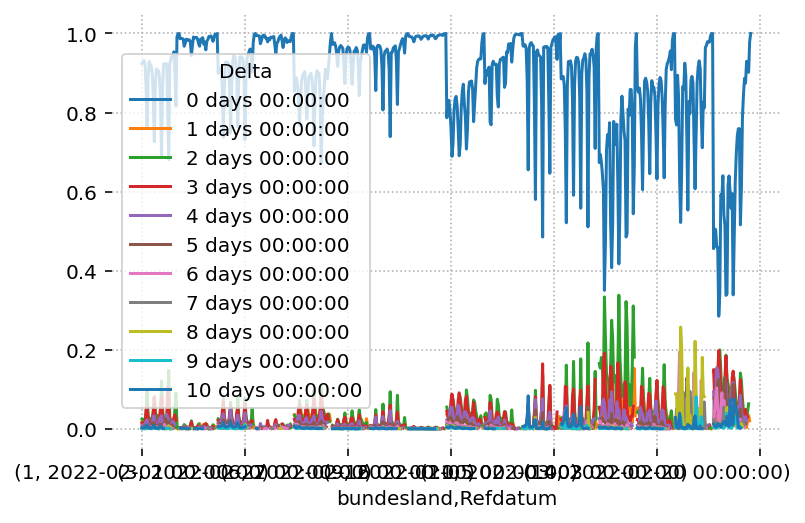

In [376]:
f.plot()

In [377]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [378]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [379]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.936918         0.952290         0.968686         0.984486   
Wed             0.934551         0.943760         0.969328         0.979511   
Thu             0.923473         0.945718         0.961060         0.965866   
Fri             0.917920         0.931015         0.940090         0.963744   
Sat             0.844797         0.855461         0.900879         0.958206   
Sun             0.734692         0.781089         0.888081         0.949928   
Mon             0.907444         0.932163         0.963306         0.975289   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.989501         0.990977         0.994872         0.996808   
Wed             0.982282         0.989907         0.995404         0.997396   
Thu             0.980594         0.992430         0.996077         0.997231   
Fri             0.983422         0.992100         0.993485         0.996051   
Sat             0.982159         0.986039         0.990634         0.991774   
Sun             0.965783         0.979272         0.984078         0.985661   
Mon             0.987154         0.990660         0.992227         0.995208   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997880         0.997553               1.0  
Wed             0.998130         0.998430               1.0  
Thu             0.998359         0.997257               1.0  
Fri             0.997112         0.997172               1.0  
Sat             0.993318         0.994753               1.0  
Sun             0.991541         0.994081               1.0  
Mon             0.997182         0.998581               1.0

In [380]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [381]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [382]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999793  0.999764  0.999635  0.999221  0.998452   
Bayern                  0.996735  0.995579  0.992735  0.984034  0.968499   
Berlin                  0.996963  0.996038  0.994795  0.990951  0.962012   
Brandenburg             0.991535  0.991475  0.989271  0.985351  0.963145   
Bremen                  1.000000  0.999673  0.999405  0.999359  0.996031   
Hamburg                 0.998754  0.999328  0.998935  0.998883  0.996604   
Hessen                  0.999265  0.999109  0.998354  0.997024  0.993126   
Mecklenburg-Vorpommern  0.997520  0.997034  0.994416  0.991108  0.981771   
Niedersachsen           0.994988  0.993927  0.991510  0.986119  0.970545   
Nordrhein-Westfalen     0.996475  0.996282  0.994428  0.988795  0.979868   
Rheinland-Pfalz         0.999047  0.998655  0.997935  0.995800  0.986272   
Saarland                0.998378  0.998431  0.998225  0.995374  0.992707   
Sachsen                 0.998379  0.997845  0.996741  0.992990  0.981901   
Sachsen-Anhalt          0.983259  0.964481  0.979144  0.941419  0.823021   
Schleswig-Holstein      0.997880  0.997396  0.996077  0.992100  0.982159   
Thüringen               0.974518  0.971358  0.949391  0.909287  0.882233   

                               5         6         7         8  
Baden-Württemberg       0.996568  0.996098  0.995841  0.995075  
Bayern                  0.934664  0.901377  0.884821  0.883944  
Berlin                  0.872684  0.980843  0.978063  0.973368  
Brandenburg             0.886321  0.956151  0.950729  0.939635  
Bremen                  0.991333  0.993915  0.989441  0.992341  
Hamburg                 0.992650  0.993483  0.990455  0.990411  
Hessen                  0.980539  0.980205  0.976153  0.970112  
Mecklenburg-Vorpommern  0.924520  0.896842  0.831422  0.798433  
Niedersachsen           0.923499  0.943028  0.948063  0.943764  
Nordrhein-Westfalen     0.947287  0.941607  0.922661  0.906129  
Rheinland-Pfalz         0.954692  0.980280  0.972541  0.970035  
Saarland                0.961776  0.949021  0.949275  0.952880  
Sachsen                 0.952371  0.947632  0.934408  0.902736  
Sachsen-Anhalt          0.739022  0.842087  0.862194  0.898150  
Schleswig-Holstein      0.949928  0.963306  0.952290  0.934551  
Thüringen               0.781395  0.746057  0.729594  0.712119

In [383]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [384]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4428        4621   
Bayern                        5946        7032        9171        8948   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1071        1057   
Bremen                          79          89          69          62   
Hamburg                        320         453         529         495   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1674        1370   
Nordrhein-Westfalen           2538        3403        4297        4299   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9242        8800        7230        9344   
Berlin                        1450         967         753        2173   
Brandenburg                   1187        1119         978        1259   
Bremen                          55          55          31          60   
Hamburg                        541         463         407         472   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4033        3722        2876        4336   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3191        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         448   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-28  2022-03-01  \
bundesland                                      ...                           
Baden-Württemberg             7123        7754  ...       20145       28708   
Bayern                       11246       12148  ...       23383       31335   
Berlin                        1919        2393  ...        6481        6479   
Brandenburg                   1495        1687  ...        5173        8156   
Bremen                         143          95  ...         553         907   
Hamburg                        533         569  ...        1794        2667   
Hessen                        1791        2067  ...        7182        9744   
Mecklenburg-Vorpommern         597         468  ...        2927        5923   
Niedersachsen                 1754        2165  ...       11274       19362   
Nordrhein-Westfalen           5171        5403  ...       22416       34219   
Rheinland-Pfalz               1139        1329  ...        6649        8984   
Saarland                       273         301  ...        1005        2380   
Sachsen                       5757        5985  ...        8113       12208   
Sachsen-Anhalt                1019        1178  ...        3951        6910   
Schleswig-Holstein             486         542  ...        5227       

In [385]:
cases_land.sum(0)

Refdatum
2021-11-01     22376
2021-11-02     27167
2021-11-03     32109
2021-11-04     31391
2021-11-05     32484
               ...  
2022-03-05    117506
2022-03-06     75437
2022-03-07    148782
2022-03-08    211494
2022-03-09    172601
Length: 129, dtype: int64

In [386]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4428        4621   
Bayern                        5946        7032        9171        8948   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1071        1057   
Bremen                          79          89          69          62   
Hamburg                        320         453         529         495   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1674        1370   
Nordrhein-Westfalen           2538        3403        4297        4299   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9242        8800        7230        9344   
Berlin                        1450         967         753        2173   
Brandenburg                   1187        1119         978        1259   
Bremen                          55          55          31          60   
Hamburg                        541         463         407         472   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4033        3722        2876        4336   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3191        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         448   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-27  2022-02-28  \
bundesland                                      ...                           
Baden-Württemberg             7123        7754  ...       11164       20145   
Bayern                       11246       12148  ...       17237       23383   
Berlin                        1919        2393  ...         608        6481   
Brandenburg                   1495        1687  ...        1012        5173   
Bremen                         143          95  ...         366         553   
Hamburg                        533         569  ...         958        1794   
Hessen                        1791        2067  ...        3039        7182   
Mecklenburg-Vorpommern         597         468  ...        1721        2927   
Niedersachsen                 1754        2165  ...        4466       11274   
Nordrhein-Westfalen           5171        5403  ...       11634       22416   
Rheinland-Pfalz               1139        1329  ...        1471        6649   
Saarland                       273         301  ...         691        1005   
Sachsen                       5757        5985  ...        3290        8113   
Sachsen-Anhalt                1019        1178  ...        3179        3951   
Schleswig-Holstein             486         542  ...        1003       

In [387]:
C = cases_land.values

In [388]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [389]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=5) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

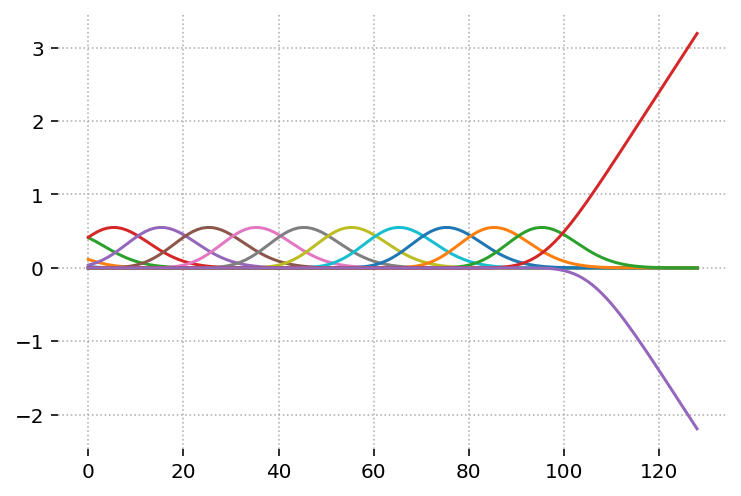

In [390]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [391]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [392]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [393]:
from numpyro.infer import Trace_ELBO

In [394]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

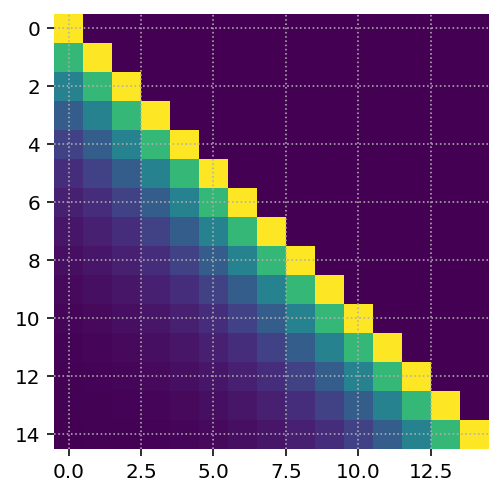

In [395]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [396]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':15000, 'lr':0.005, 'lrd': 0.2 ** (1/10000), 'num_samples': 100}

)

In [397]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 15,000 | 0 %
SVI step 1,000 / 15,000 | 7 %
SVI step 2,000 / 15,000 | 13 %
SVI step 3,000 / 15,000 | 20 %
SVI step 4,000 / 15,000 | 27 %
SVI step 5,000 / 15,000 | 33 %
SVI step 6,000 / 15,000 | 40 %
SVI step 7,000 / 15,000 | 47 %
SVI step 8,000 / 15,000 | 53 %
SVI step 9,000 / 15,000 | 60 %
SVI step 10,000 / 15,000 | 67 %
SVI step 11,000 / 15,000 | 73 %
SVI step 12,000 / 15,000 | 80 %
SVI step 13,000 / 15,000 | 87 %
SVI step 14,000 / 15,000 | 93 %


Text(0, 0.5, 'ELBO')

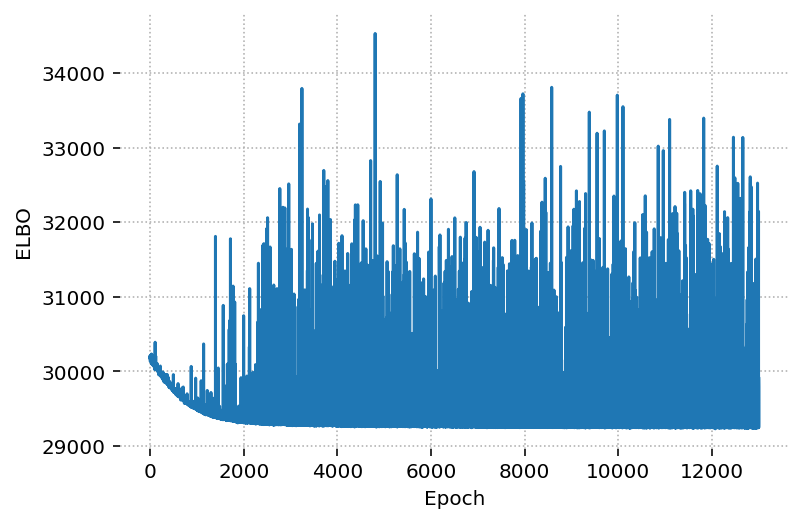

In [398]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

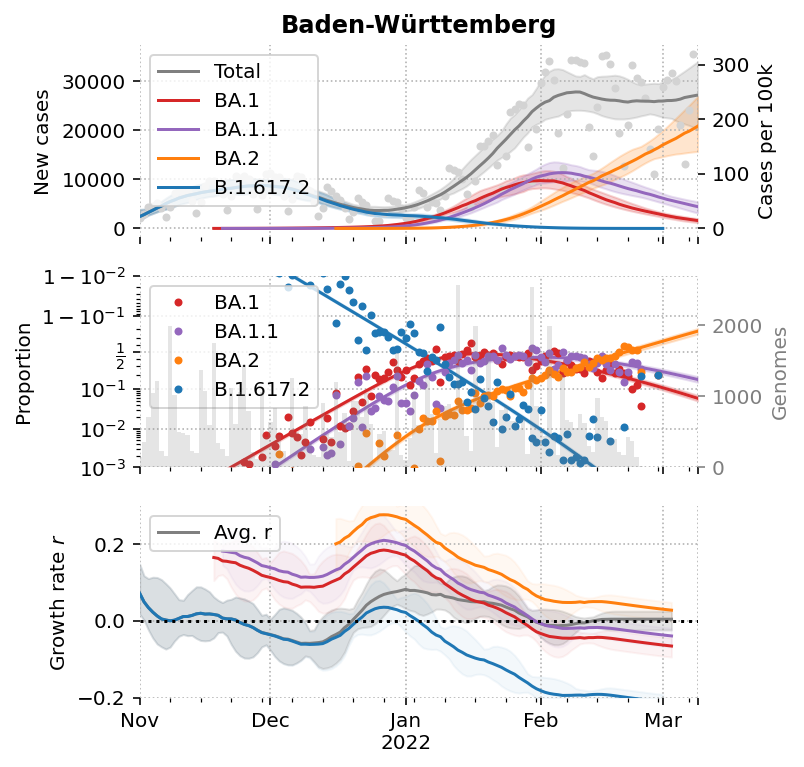

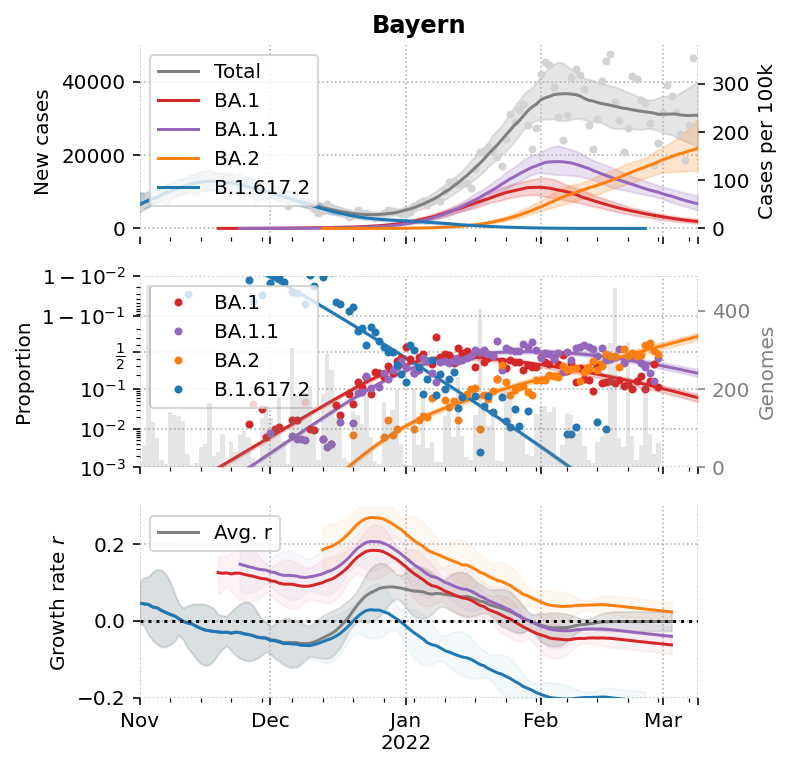

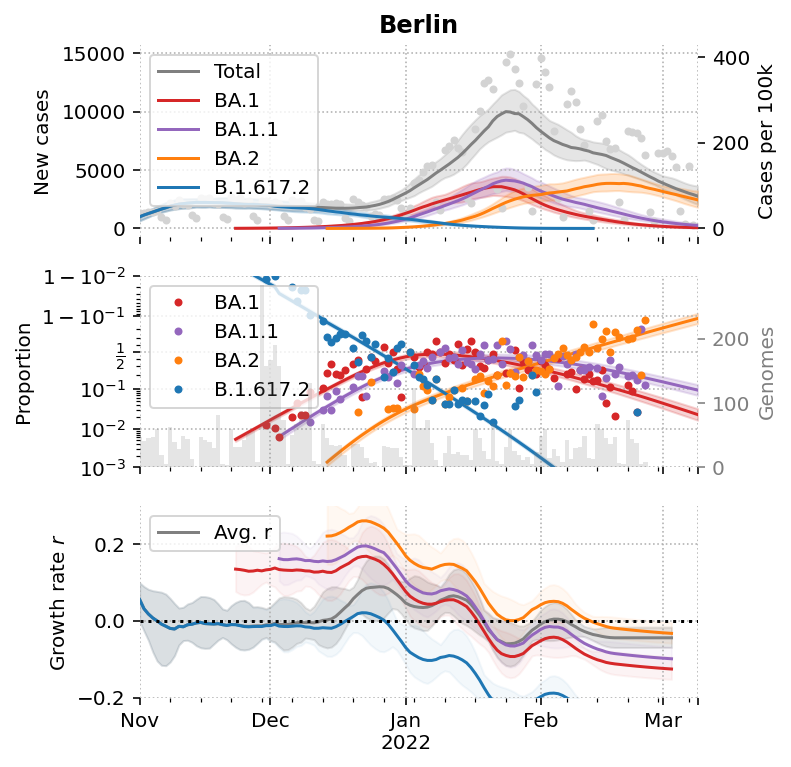

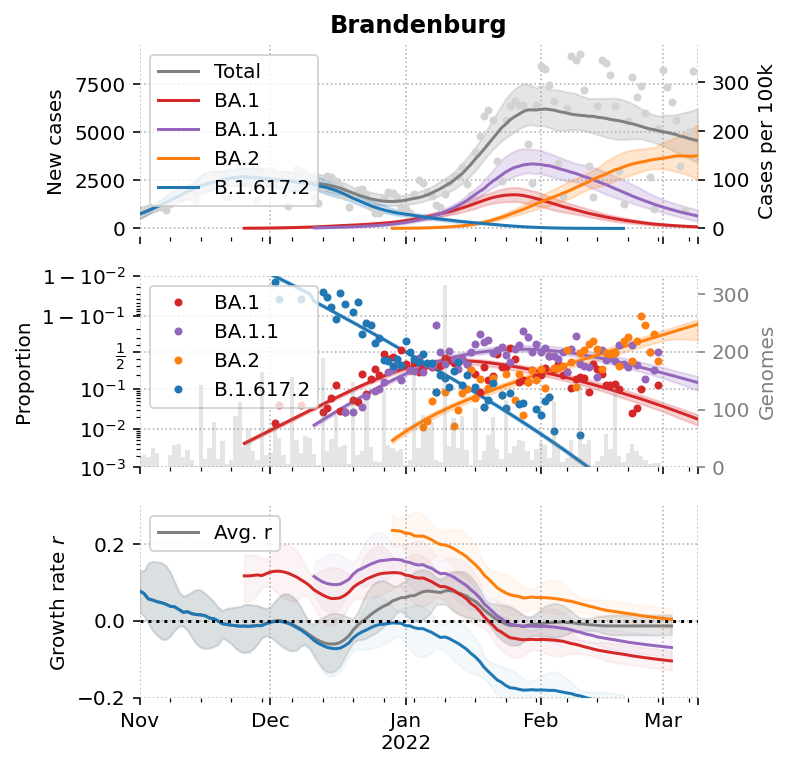

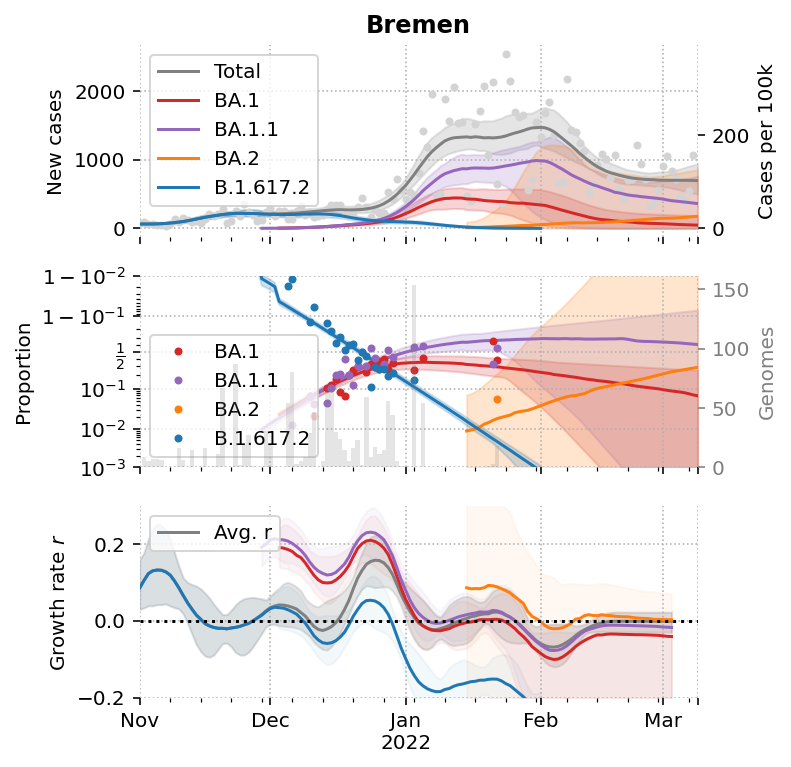

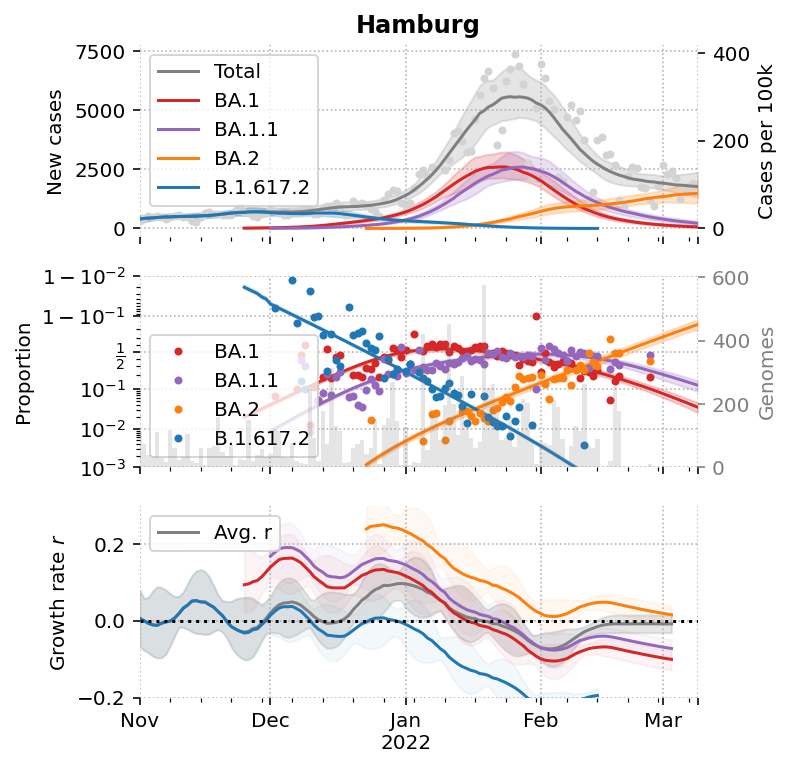

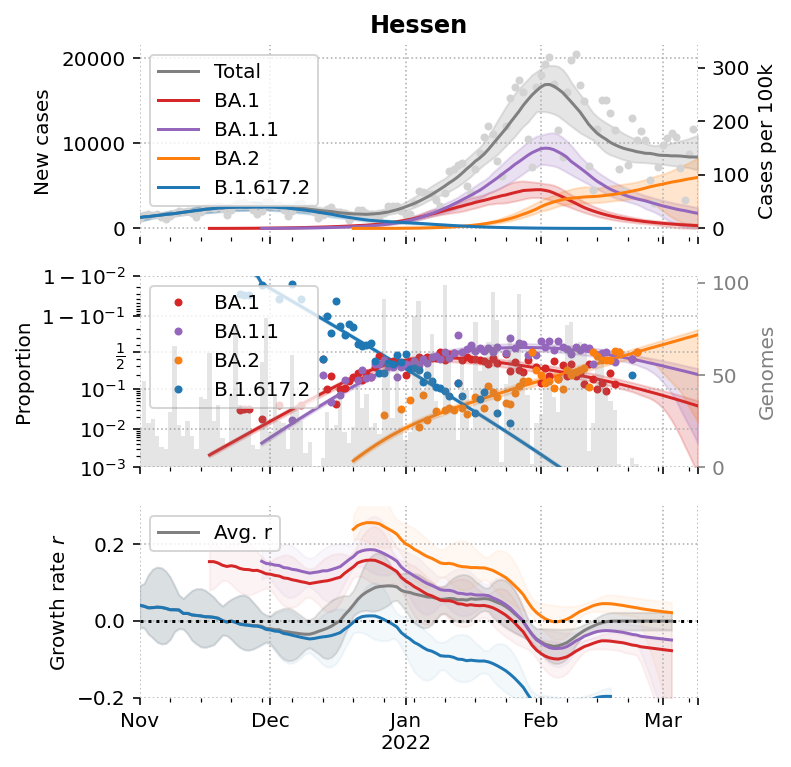

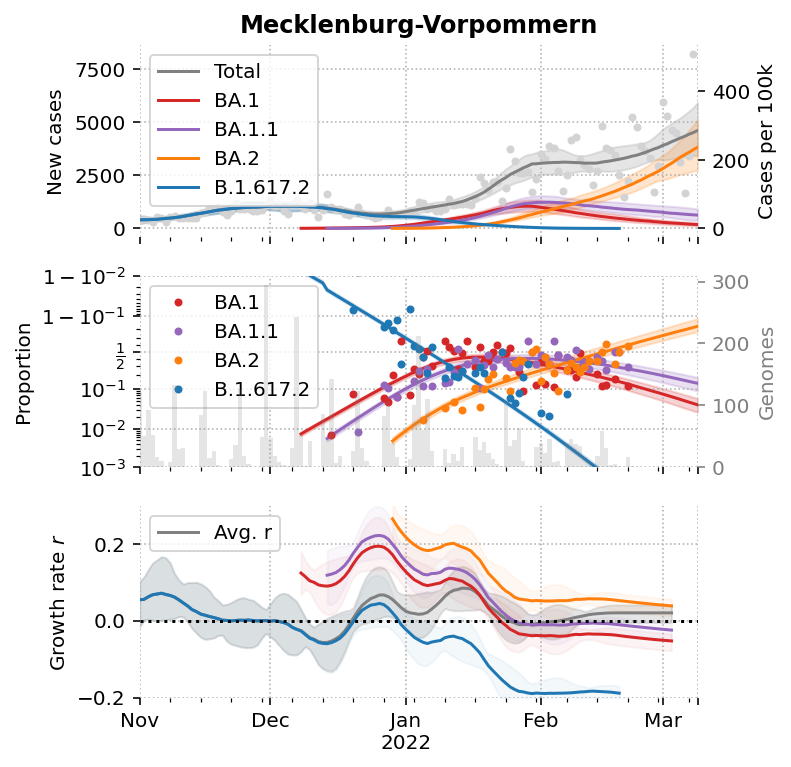

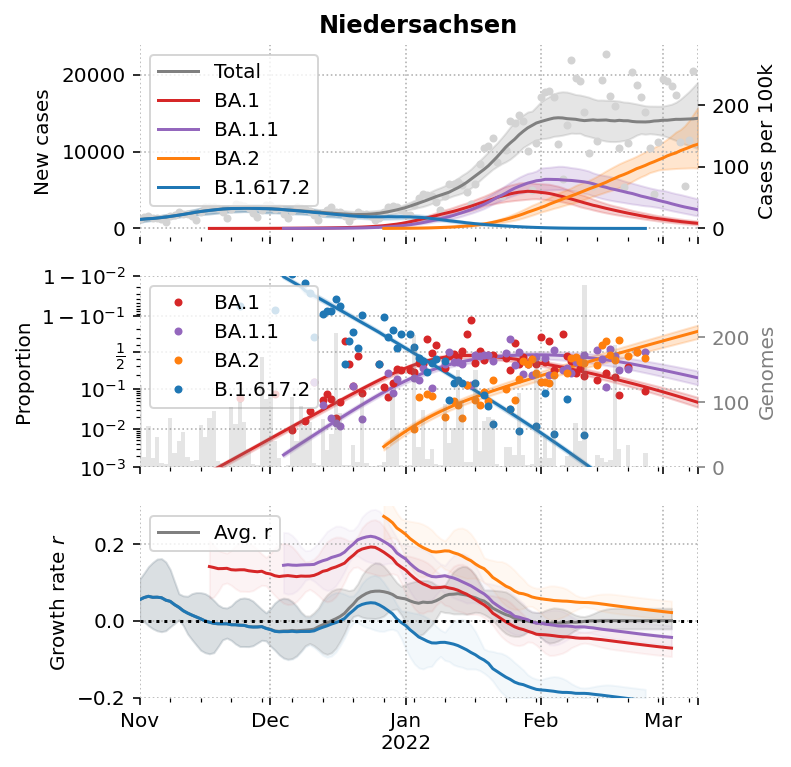

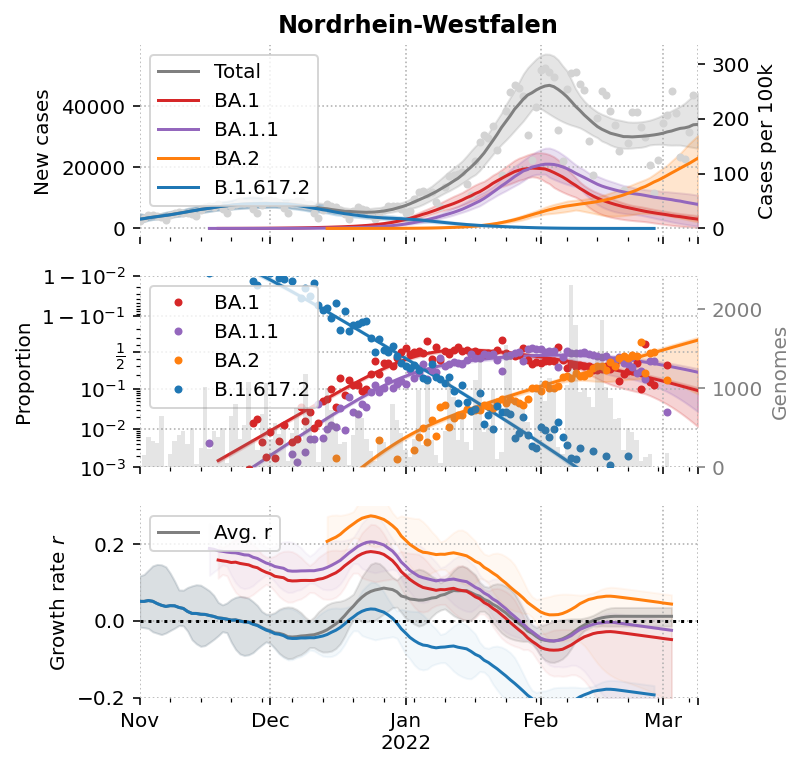

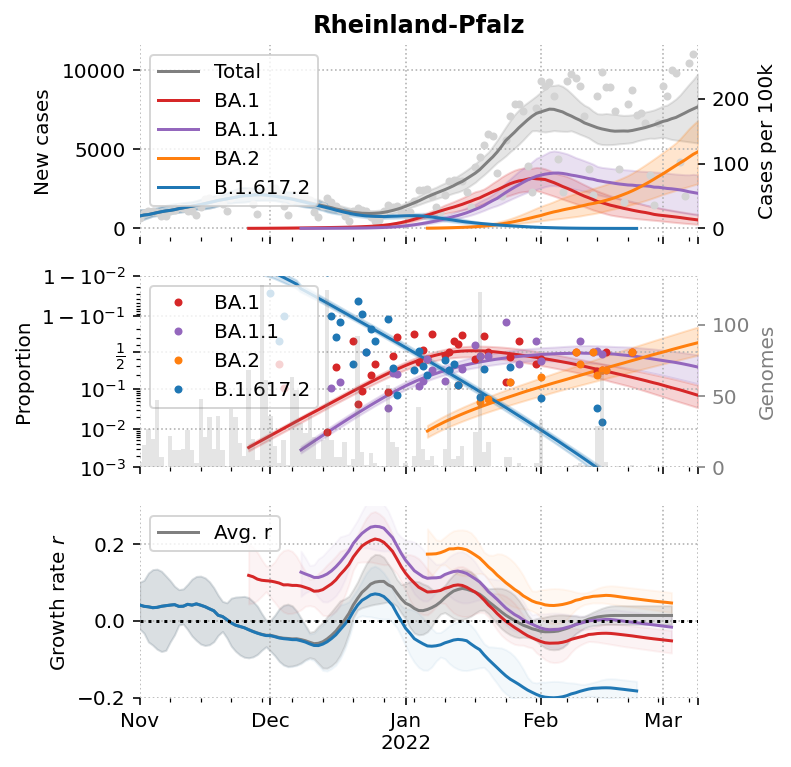

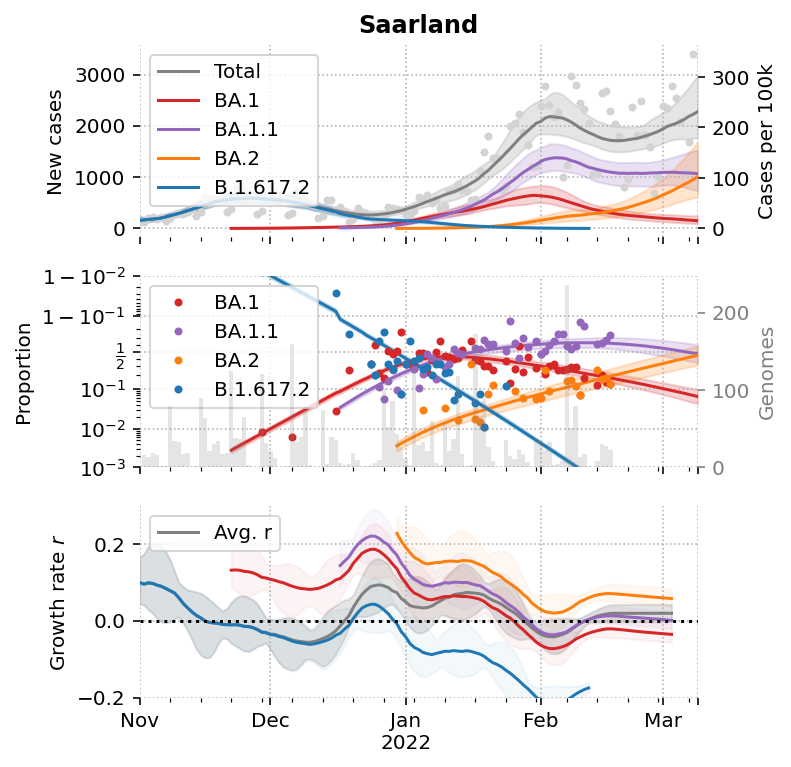

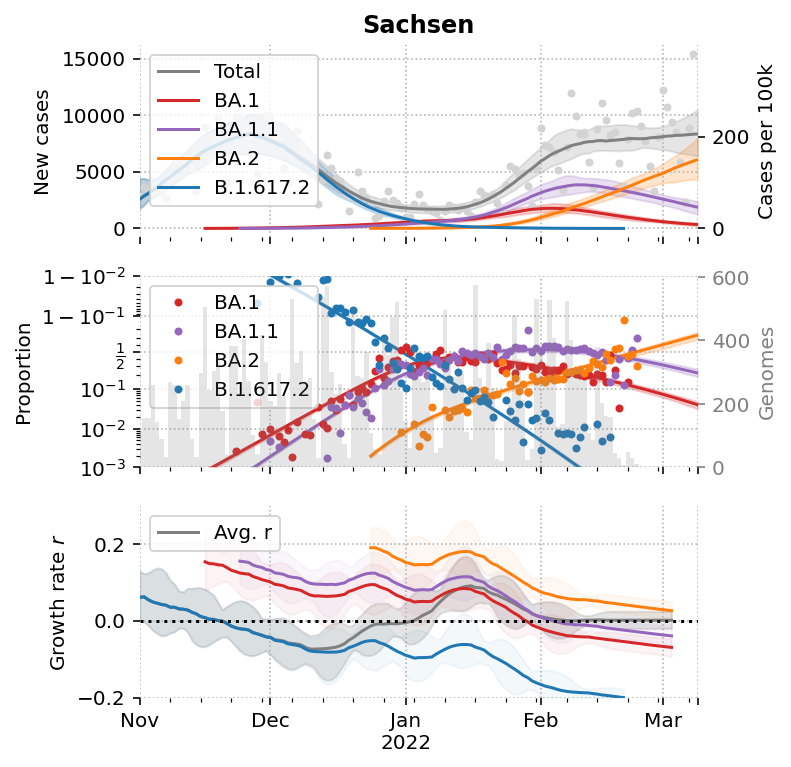

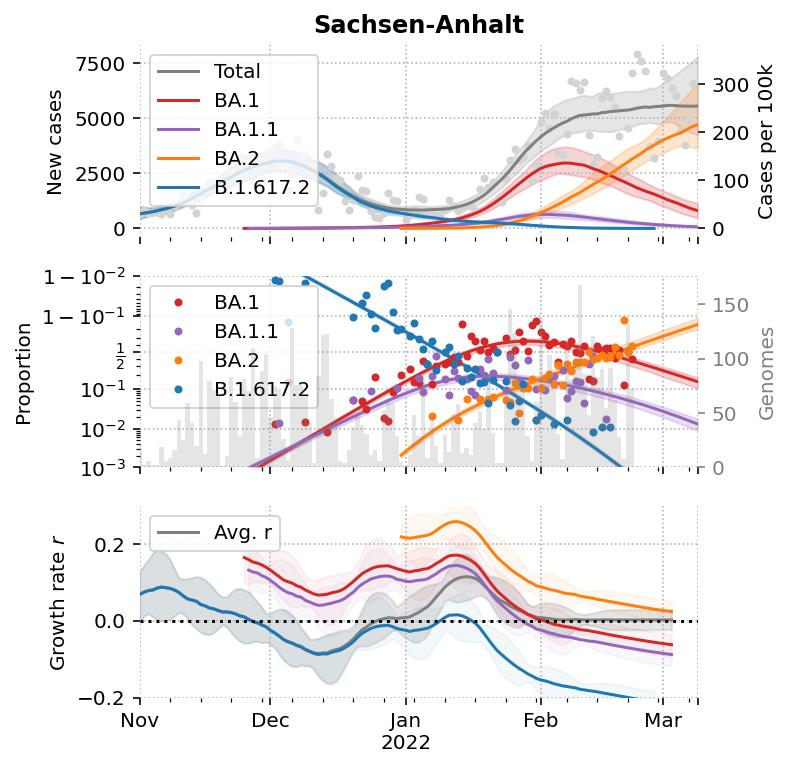

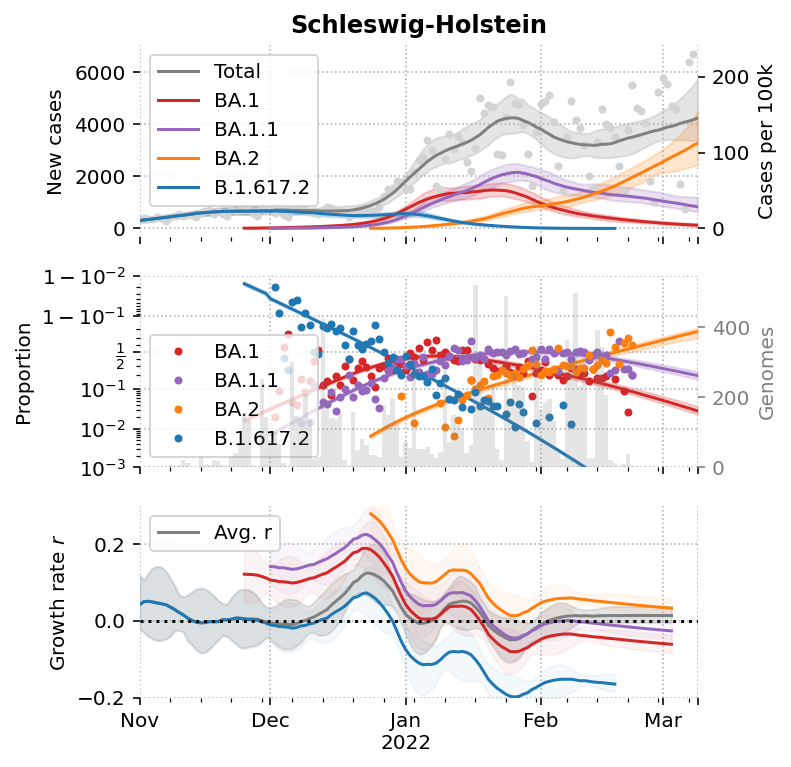

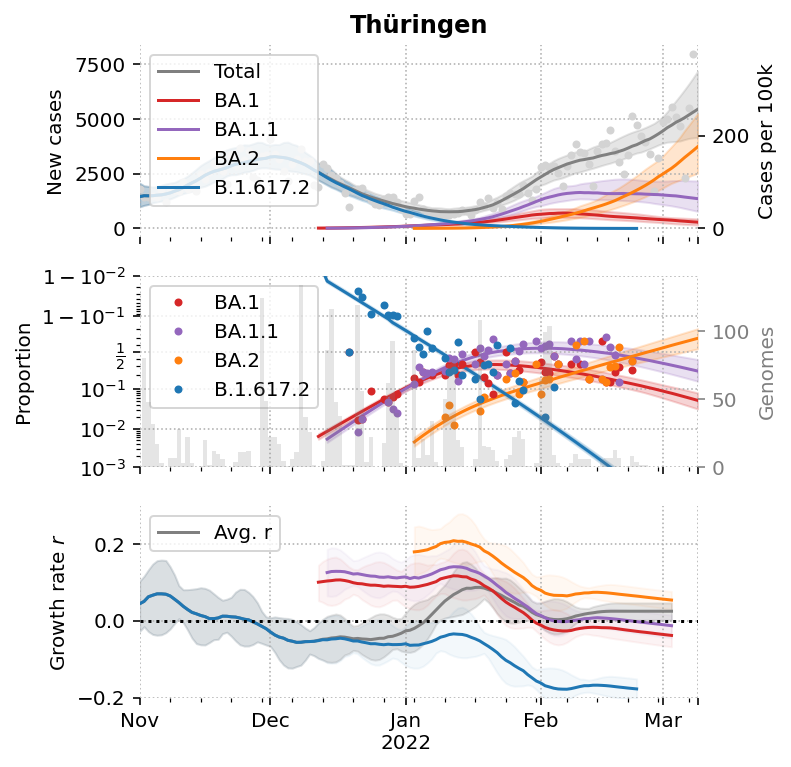

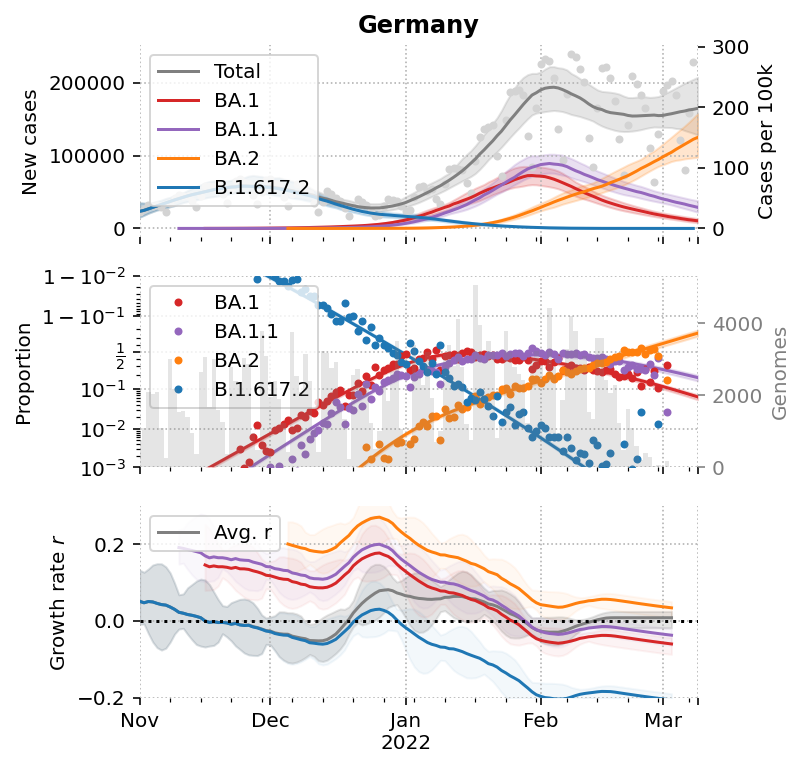

In [429]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [400]:
genomes.sum(level=1).loc["2022-01-10":,:]

lineage     BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
date                                                  
2022-01-10  1368     906   100     0     19        747
2022-01-11  1551    1181    66     1      4        580
2022-01-12  1336    1087    58     1      6        331
2022-01-13  1663    1748   163     0      5        530
2022-01-14  1335    1039    88     0      0        313
2022-01-15   619     479    44     2      0         56
2022-01-16   381     303    39     0      0         45
2022-01-17  2167    2287   334     2      1        277
2022-01-18  1782    1645   173     0      1        336
2022-01-19  1407    1182   171     0      4        168
2022-01-20  1523    1620   219     0      2        130
2022-01-21  1455    1443   225     0      1         68
2022-01-22   329     378    60     0      0         57
2022-01-23   465     568   116     0      0         17
2022-01-24  1605    1686   385     0      0        102
2022-01-25  1341    1498   240     0      0        118
2022-01-26  1058    1360   327     0      0         34
2022-01-27   995    1245   275     0      0         63
2022-01-28  1027    1085   255     0      0         66
2022-01-29   475     597   141     0      0         13
2022-01-30   807    1692   515     0      0         19
2022-01-31  1009    1666   530     0      1         28
2022-02-01  1030    1374   388     0      0         36
2022-02-02   872    1101   396     0      0         25
2022-02-03  1271    2253   880     1      2         27
2022-02-04  1002    1305   454     1      0         17
2022-02-05   394     380   183     0      0          6
2022-02-06   483     901   474     0      0          5
2022-02-07   935    1572   766     2      0         20
2022-02-08  1337    1967   871     3      0         13
2022-02-09  1034    1819   922     3      0          6
2022-02-10   833    1353   788     0      0          7
2022-02-11   773    1457   848     0      1          7
2022-02-12   450     661   435     1      0          2
2022-02-13   334     561   429     1      2          7
2022-02-14   865    1478  1237     0      0         14
2022-02-15   843    1523  1225     2      0          4
2022-02-16   606     949   861     2      1          3
2022-02-17   558     669   822     0      2          5
2022-02-18   483     829   960     1      0          0
2022-02-19   223     456   540     2      0          0
2022-02-20    92     124   261     0      7          2
2022-02-21   339     468   808     0      0          1
2022-02-22   197     354   551     2      0          1
2022-02-23   140     156   292     0      0          1
2022-02-24    22      51   106     0      7          5
2022-02-25   106     100   184     0      0          0
2022-02-26    40      92   148     0      0          0
2022-02-27    12      10    27     0      0          0
2022-02-28     8      31    33     0      2          1
2022-03-02    58       5    29     0     89          0

In [401]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [402]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

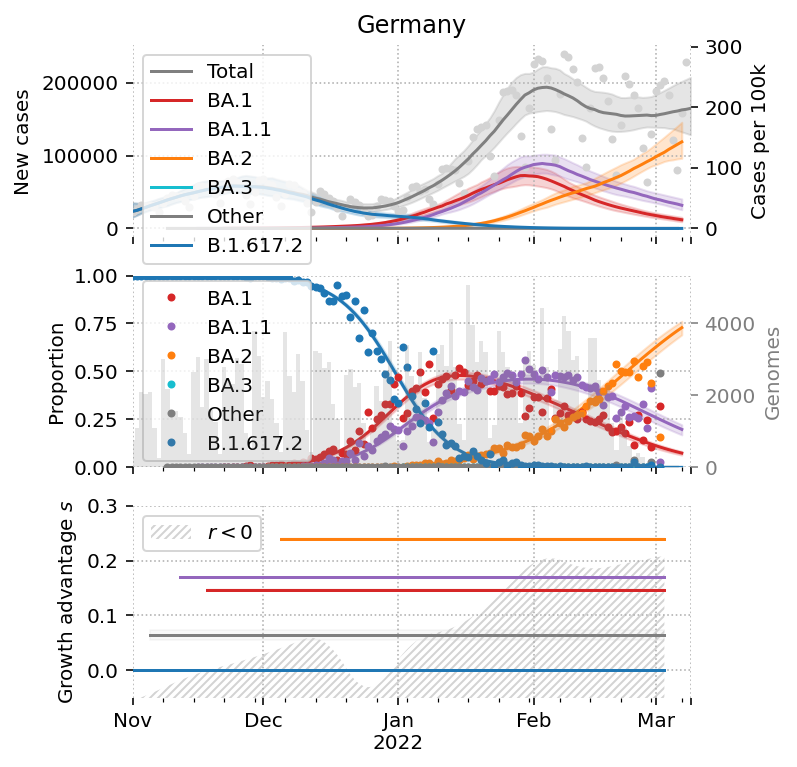

In [403]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [404]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [405]:
λ.shape

(17, 129, 6)

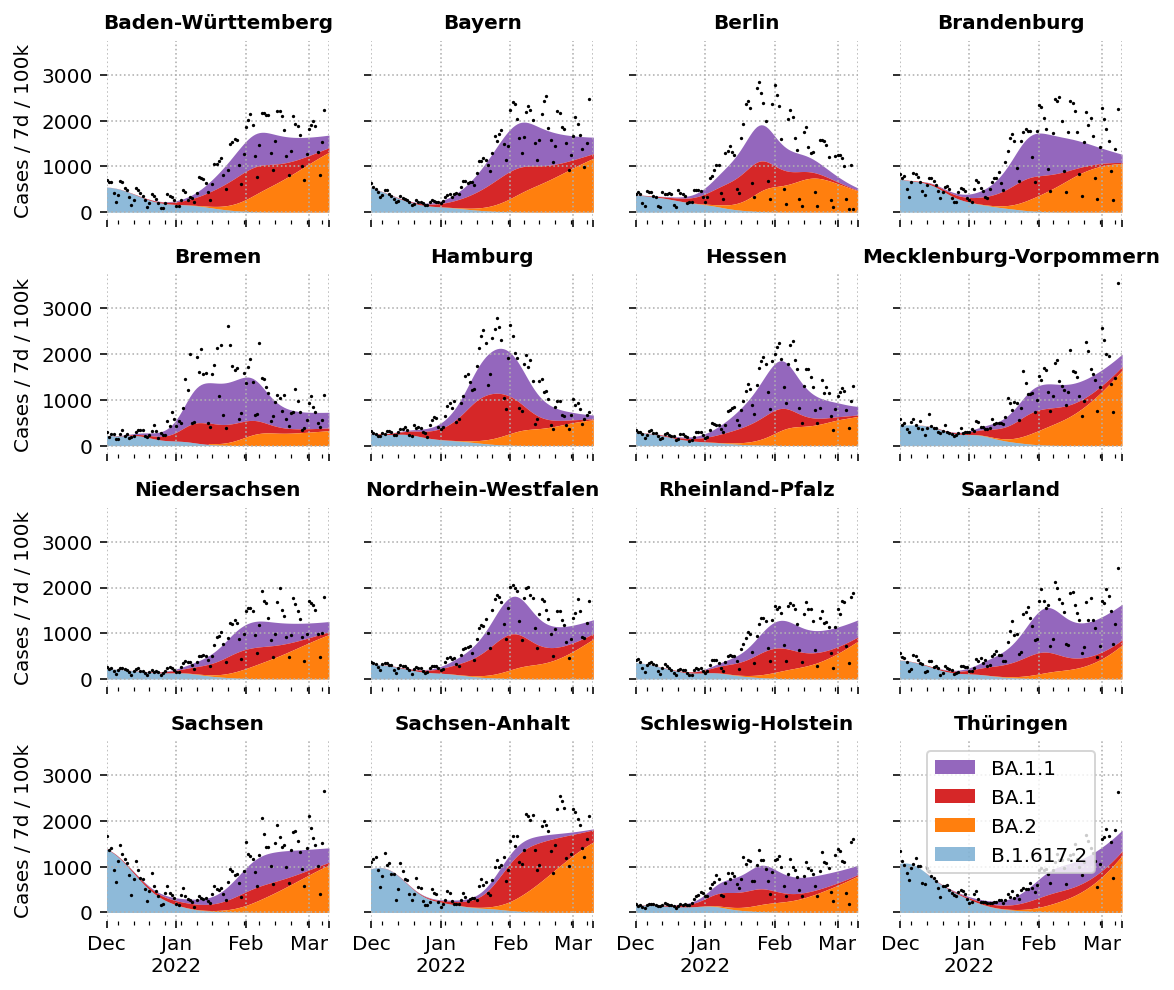

In [406]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [407]:
λ[-1,-1] / λ[-1,-1].sum()

array([6.42349873e-02, 1.78040305e-01, 7.55650272e-01, 2.06414885e-03,
       5.11515146e-06, 5.17153735e-06])

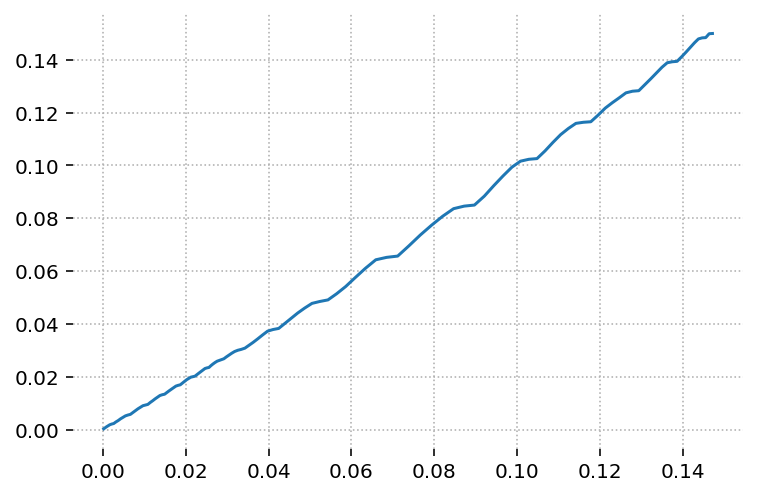

In [408]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [409]:
from genomicsurveillance.misc import get_transmissibility

In [410]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.149142  0.174853  0.242260 -0.129705  0.014852   
Bayern                  0.154890  0.177788  0.241107 -0.111660  0.064737   
Berlin                  0.145903  0.173848  0.239291 -0.111660  0.021423   
Brandenburg             0.131342  0.166093  0.241010 -0.129188  0.040659   
Bremen                  0.155419  0.177884  0.225265 -0.111660  0.066015   
Hamburg                 0.125863  0.154327  0.242278 -0.128780  0.064036   
Hessen                  0.144559  0.172088  0.242210 -0.129523  0.015636   
Mecklenburg-Vorpommern  0.150057  0.177712  0.241175 -0.111660  0.040659   
Niedersachsen           0.144485  0.172951  0.237739 -0.111660  0.046370   
Nordrhein-Westfalen     0.150137  0.174887  0.242330 -0.130027  0.047057   
Rheinland-Pfalz         0.141743  0.177654  0.241029 -0.111660  0.016009   
Saarland                0.142585  0.178088  0.234863 -0.111660  0.014730   
Sachsen                 0.145760  0.176018  0.242228 -0.129511  0.066618   
Sachsen-Anhalt          0.155328  0.129269  0.242326 -0.129312  0.040659   
Schleswig-Holstein      0.117838  0.152971  0.211855 -0.129410  0.015837   
Thüringen               0.151350  0.175079  0.242240 -0.111660  0.025710   
Germany                 0.145952  0.169029  0.240025 -0.129780  0.065200   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       108222                   0.073666  0.010105   
BA.1.1     115320                   0.088697  0.012507   
BA.2        41352                   0.152562  0.007834   
BA.3           62                  -0.111660  0.032641   
Other         598                   0.040659  0.022510   
B.1.617.2  237636                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.010105  
BA.1.1                           0.025187  0.012507  
BA.2                             0.093934  0.007834  
BA.3                            -0.273727  0.032641  
Other                           -0.105383  0.022510  
B.1.617.2                       -0.144256  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


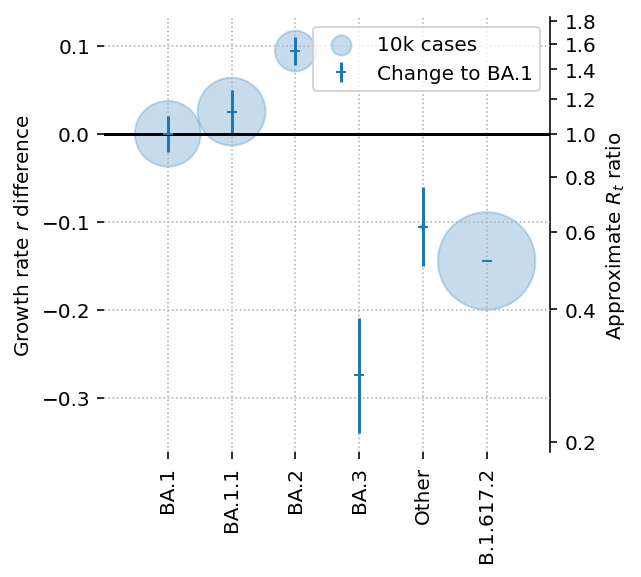

In [411]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [412]:
import geopandas as gpd

In [413]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [414]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [415]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-25     0       2     0     0      0          0
                  2022-02-26     0       0     0     0      0          0
                  2022-02-27     0       0     0     0      0          0
                  2022-02-28     0       0     0     0      0          0
                  2022-03-02     0       0     0     0      0          0

[1936 rows x 6 columns]

In [416]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([5.99713733e-02, 2.07602256e-01, 7.22572479e-01, 6.44363827e-03,
       3.40291549e-03, 7.33851446e-06])

In [417]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


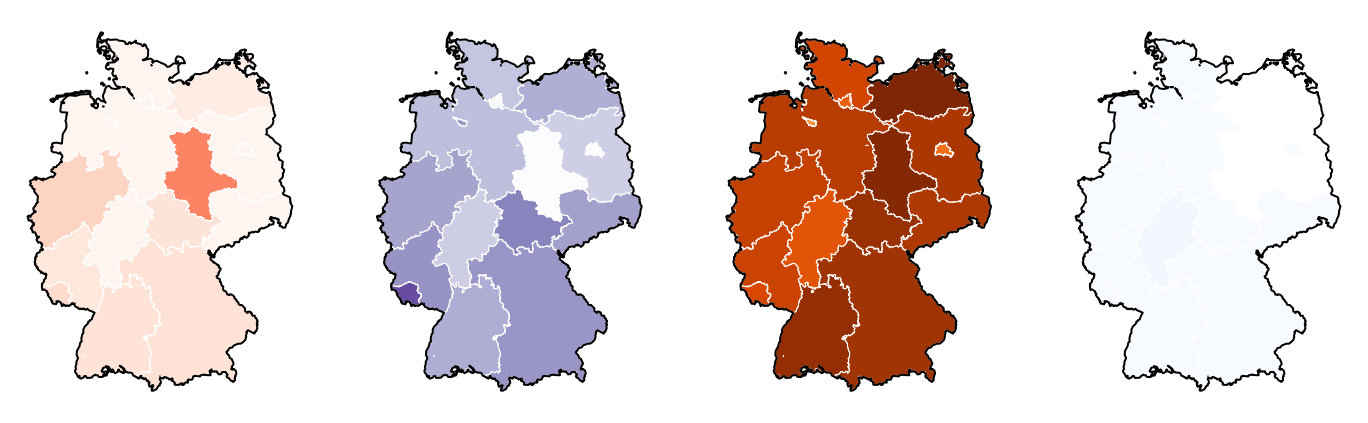

In [418]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [419]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1       BA.1.1          BA.2         BA.3  \
bundesland                                                                    
Baden-Württemberg       1580.902024  4358.241856  20783.366207     0.017265   
Bayern                  1879.785961  6796.719848  22101.986523     0.000000   
Berlin                    65.703488   261.238514   2453.007044     0.000000   
Brandenburg               81.824571   650.739899   3848.184468    75.149335   
Bremen                    57.574001   334.231169    316.357702     0.000000   
Hamburg                   63.767918   215.879553   1489.840039    36.583353   
Hessen                   306.511264  1665.170059   5730.786490   145.187998   
Mecklenburg-Vorpommern   187.676460   622.491536   3792.482381     0.000000   
Niedersachsen            684.487645  2565.737641  11126.622468     0.000000   
Nordrhein-Westfalen     3028.049954  7783.976503  22391.763360  1194.572544   
Rheinland-Pfalz          539.274388  2183.394866   4839.936933     0.000000   
Saarland                 153.482774  1094.127655   1049.727548     0.000000   
Sachsen                  340.502381  1838.941518   6008.204208   122.131298   
Sachsen-Anhalt           819.737059    74.857967   4800.853585    34.561499   
Schleswig-Holstein       125.576506   860.668462   3306.110351    53.185544   
Thüringen                293.208136  1379.385127   3773.476284     0.000000   

                             Other  B.1.617.2  
bundesland                                     
Baden-Württemberg         0.868336   0.183126  
Bayern                    0.130477   0.076606  
Berlin                    0.007526   0.002313  
Brandenburg               0.000000   0.022592  
Bremen                    0.006303   0.000682  
Hamburg                   0.011758   0.006398  
Hessen                  688.252927   0.013280  
Mecklenburg-Vorpommern    0.000000   0.029076  
Niedersachsen             0.043547   0.087294  
Nordrhein-Westfalen       0.029227   0.134710  
Rheinland-Pfalz           0.014191   0.072917  
Saarland                  0.018149   0.012589  
Sachsen                   0.020743   0.030193  
Sachsen-Anhalt            0.000000   0.130083  
Schleswig-Holstein        0.020305   0.036411  
Thüringen                 0.106626   0.086720

In [433]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-7.00069056e-02, -4.42646189e-02,  2.30718892e-02,
        -3.86805295e-01, -2.02015387e-01, -2.19139256e-01],
       [-6.55830568e-02, -4.25349185e-02,  2.04954419e-02,
        -2.20425532e-01, -1.55702559e-01, -2.20425532e-01],
       [-1.27038644e-01, -9.91406677e-02, -3.37980756e-02,
        -2.73008052e-01, -2.47049876e-01, -2.73008052e-01],
       [-1.06940256e-01, -7.22681887e-02,  2.47991937e-03,
        -3.65800956e-01, -2.38345541e-01, -2.38345541e-01],
       [-9.96831607e-02, -7.86120198e-02, -2.00282502e-02,
        -2.56191669e-01, -1.94066880e-01, -2.56191669e-01],
       [-1.12901167e-01, -8.45942285e-02,  3.58920175e-03,
        -4.26004074e-01, -1.74897505e-01, -2.38883810e-01],
       [-1.06118773e-01, -7.89021803e-02, -8.52711961e-03,
        -4.04634474e-01, -1.93934714e-01, -2.50793594e-01],
       [-5.54616361e-02, -2.78187985e-02,  3.55985505e-02,
        -2.05676451e-01, -2.05676451e-01, -2.05676451e-01],
       [-7.16665382e-02, -4.31159832e-02,  2.170

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


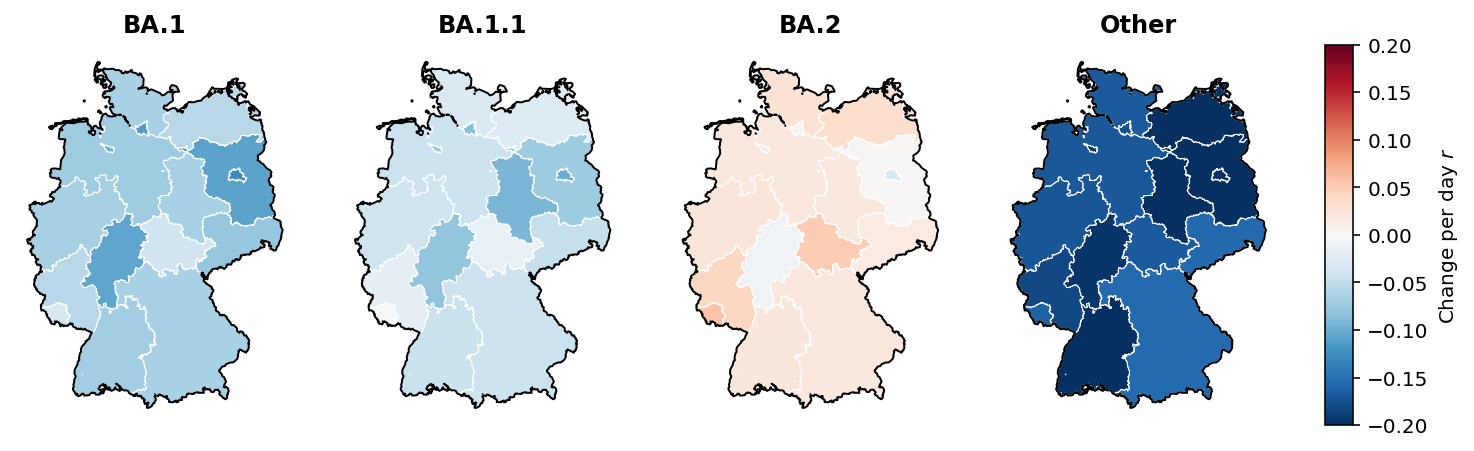

In [434]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [435]:
ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,-5,2], (0.1, 0.9), axis=0)

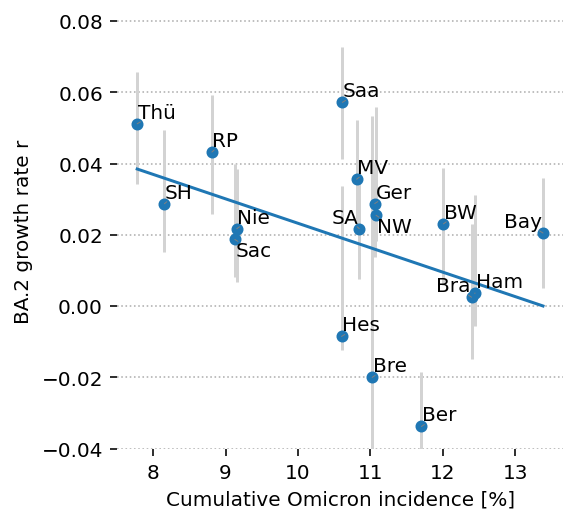

In [436]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
plt.figure(figsize=(4,4))
lr = LR()
x = λ[...,:3].sum((1,2)) * 100
y = r[:,2]
lr.fit(x[:,np.newaxis], y)
plt.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color='C0', ecolor='lightgrey')
import re
l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
text=[]
for i in range(x.shape[0]):
    text.append(plt.text(x[i], y[i], l[i], color='k', va='center', ha='center'))
x.sort()
y = lr.predict(x[:,np.newaxis])
line = plt.plot(x, y, ls="-")
#plt.axline((0, lr.intercept_), slope=lr.coef_)
#plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
plt.xlabel("Cumulative Omicron incidence [%]")
plt.ylabel("BA.2 growth rate r")
plt.ylim((-0.04,None))
adjust_text(text, 
            #add_objects=line, 
            #expand_objects = (1,1),
            #force_objects =  (0, 0.2),
            #only_move=dict(objects='y', text='y', points='y'),
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5), )
plt.grid(axis='x', which='major')

In [205]:
lr.intercept_

0.10112428459059733

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


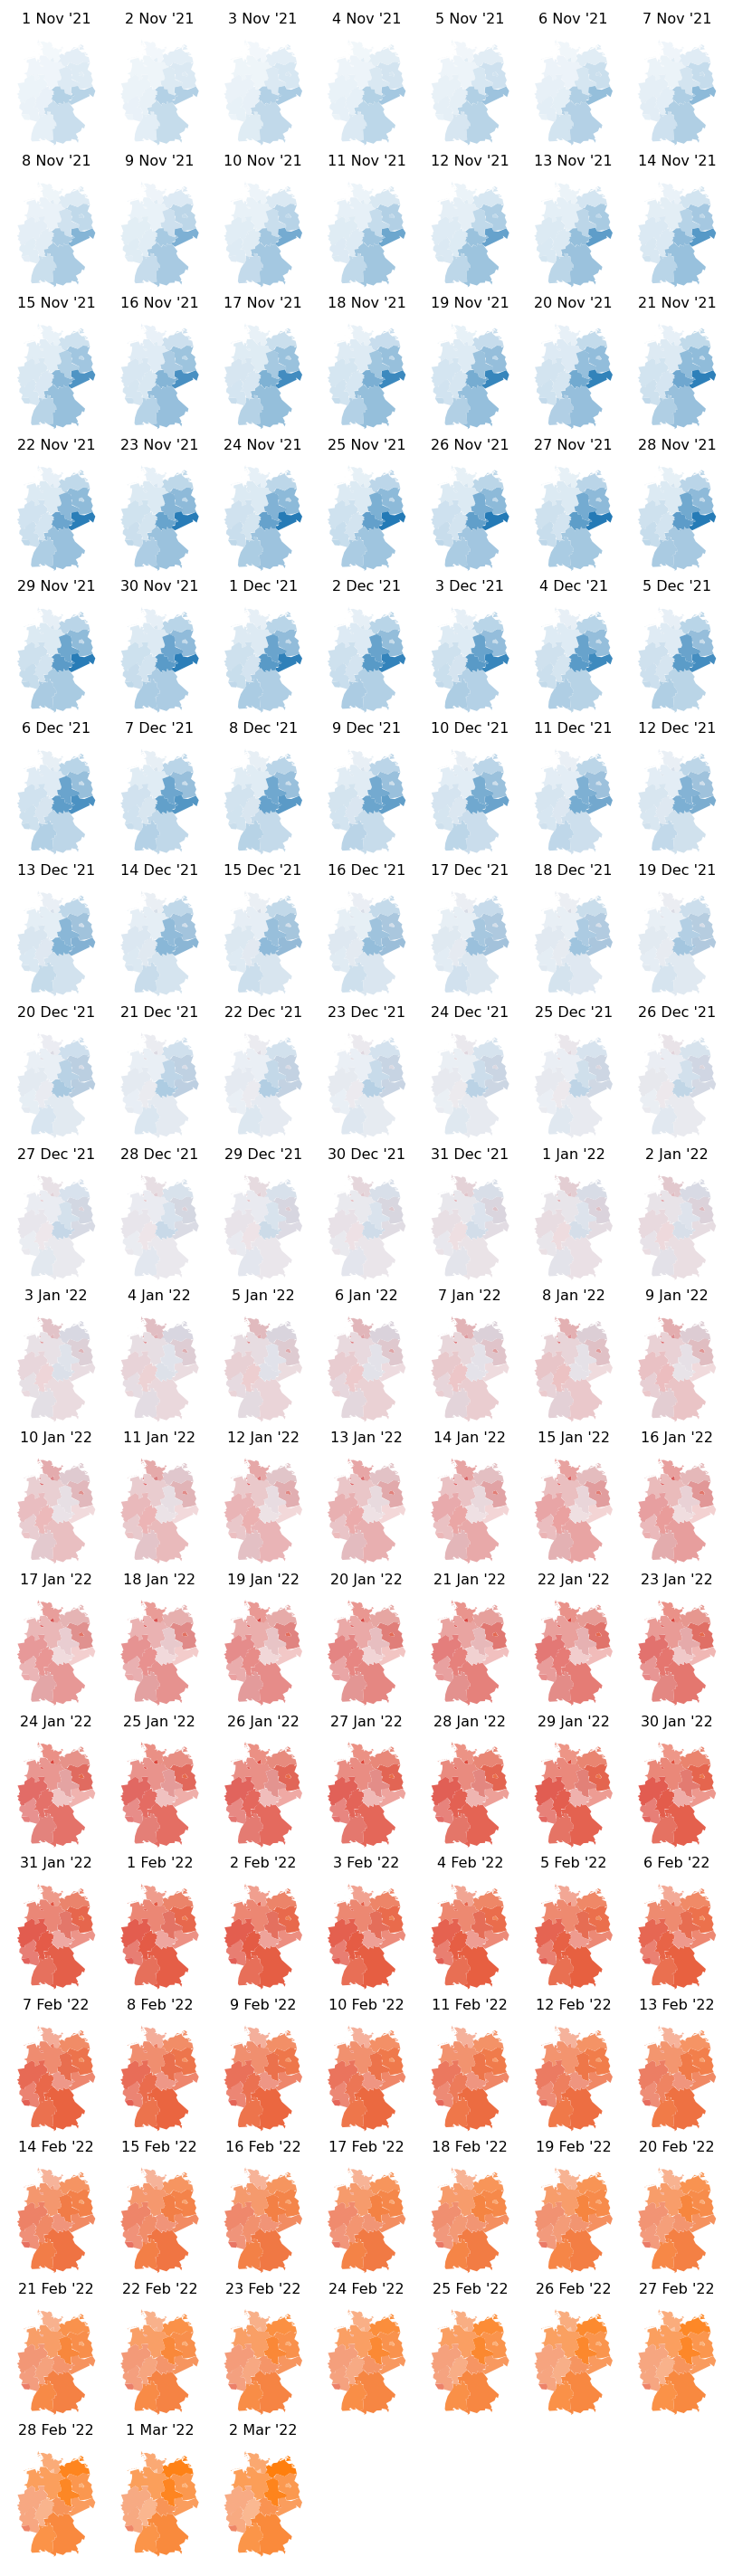

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


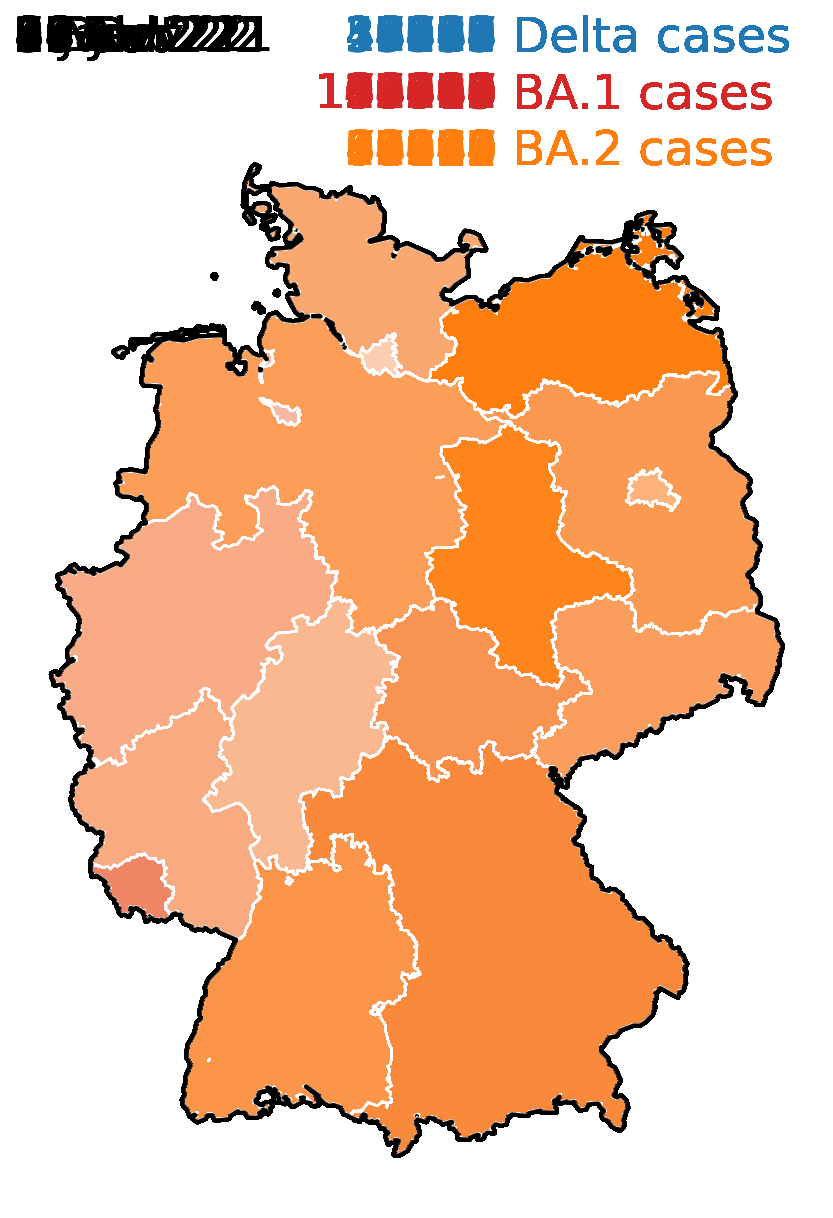

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

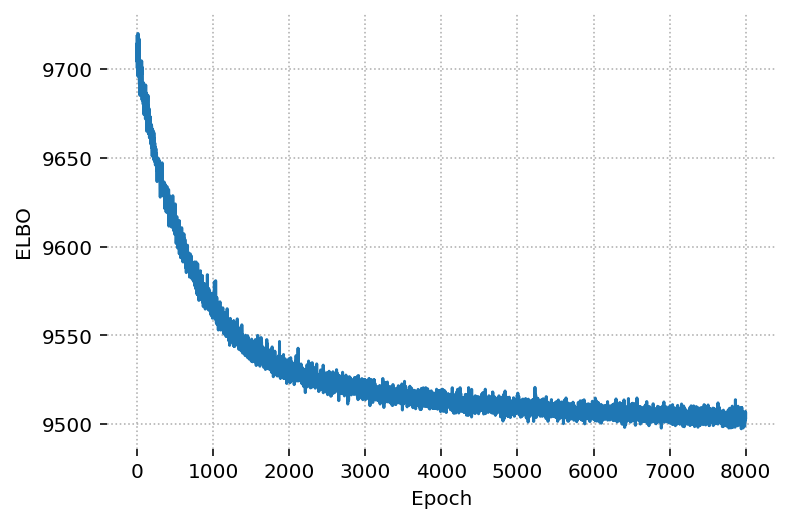

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

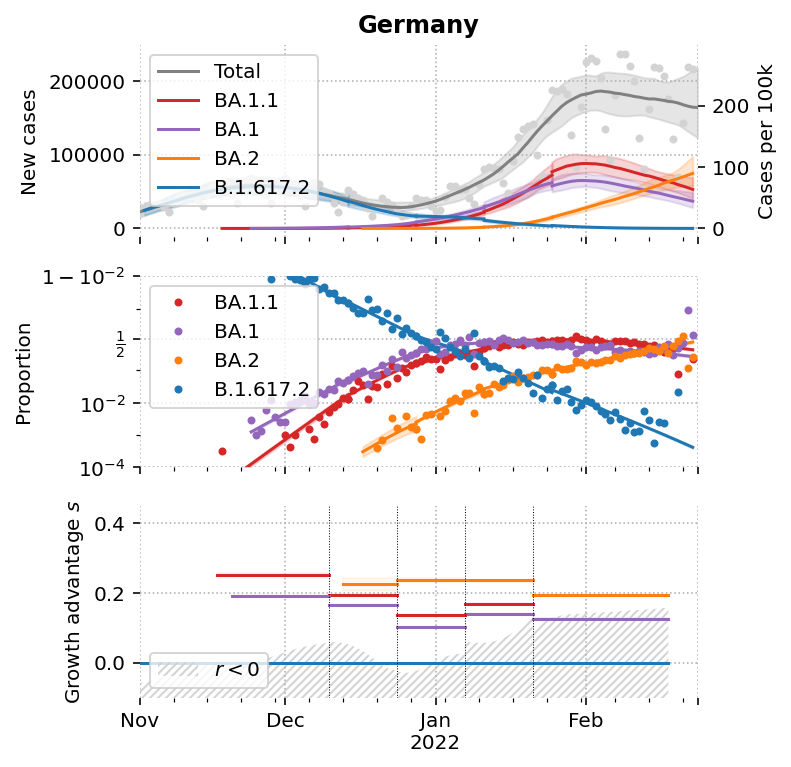

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


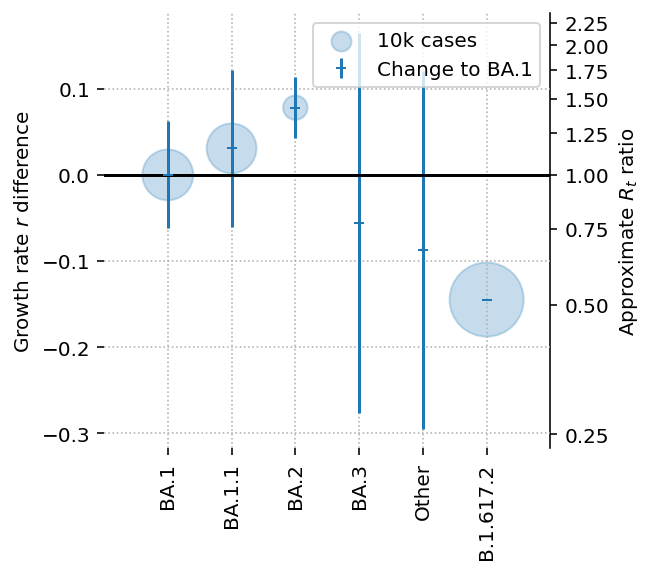

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
